In [1]:
from e2eml.full_processing import postprocessing
from e2eml.regression import regression_blueprints as rb
from e2eml.classification import classification_blueprints as cb
from e2eml.timetravel import timetravel

import pandas as pd
from sklearn import model_selection
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
import re
import numpy as np
pd.set_option('display.max_colwidth', None)
from statsmodels.tsa import stattools


import pickle
import gc

[nltk_data] Downloading package punkt to /home/thomas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/thomas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/thomas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/thomas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
full_df = pd.read_csv("AirPassengers.csv")
full_df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [5]:
list(full_df.columns.difference(["#Passengers"]))

['Month']

In [6]:
original_target = "#Passengers"

In [7]:
target_sensor = original_target
features = list(full_df.columns.difference([target_sensor]))

forecast_lead = 20
target = f"{target_sensor}_lead{forecast_lead}"

full_df[target] = full_df[target_sensor].shift(-forecast_lead)
full_df = full_df.iloc[:-forecast_lead]

<AxesSubplot:>

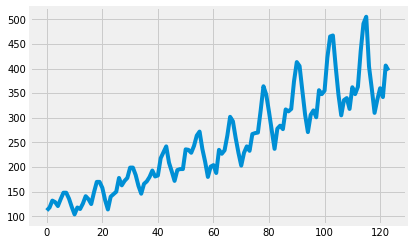

In [8]:
full_df[original_target].plot()

<AxesSubplot:>

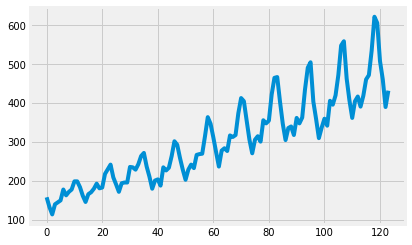

In [9]:
full_df[target].plot()

In [10]:
# add rolling features
def add_rolling_feature(dataframe, col_list, marker_text, time_window):
    """Takes a dataframe, column to use and a time window to create a rolling mean.
    :params:
    dataframe: the dataframe to use the feature from
    col:_name: the column to be used for the rolling feature
    col_list: list of calls to loop through
    marker_text: unique marker to prevent join attachments like x & y
    time_window: number of days to roll over
    returns: the modified dataframe
    """
    for columns in col_list:
        dataframe[f"rolling_avg_{columns}_{time_window}D_{marker_text}"] = dataframe[columns].rolling(window=time_window).mean()
    return dataframe

def add_shifted_features(dataframe, col_list, marker_text, time_window):
    for columns in col_list:
        dataframe[f"shifted_{columns}_{time_window}D_{marker_text}"] = dataframe[columns].shift(time_window)
    return dataframe

    
# verify, that we don't have NULLs left
def raise_nulls(dataframe):
    return print(dataframe.isna().sum().sum())


window_list = [i for i in range(2, 31)]
col_list = full_df.columns.to_list()
col_list.remove("Month")
col_list.remove(target)

for days in window_list:
    add_rolling_feature(full_df, col_list, "fd", days)
    

shift_window_list = [i for i in range(1, 31)]
for days in shift_window_list:
    add_shifted_features(full_df, col_list, "fd", days)

In [11]:
full_len = len(full_df.index)
time_df = full_df.head(full_len-forecast_lead)
holdout_df = full_df.tail(forecast_lead)
val_df_target = holdout_df[target]

In [12]:
del holdout_df[target]

In [13]:
(time_df.index.min(), time_df.index.max())

(0, 103)

In [14]:
(holdout_df.index.min(), holdout_df.index.max())

(104, 123)

# Time seris test

In [15]:
from e2eml.time_series import time_series_blueprints as tsb

In [16]:
ts = tsb.TimeSeriesBluePrint(datasource=time_df,
                                       target_variable=target,
                                       preferred_training_mode='auto',
                                       ml_task='time_series',
                                       rapids_acceleration=False,
                                       cat_encoder_model='target')

Ml task is time_series
Preferred training mode auto has been chosen. e2eml will automatically detect, if LGBM and Xgboost can use GPU acceleration and optimize the workflow accordingly.


In [17]:
ts.target_variable

'#Passengers_lead20'

In [18]:
ts.ml_bp103_multivariate_timeseries_full_processing_rnn()

Started Execute test train split at 11:43:57.
Started Started column type detection and casting at 11:43:57.
Started Checking for duplicate columns at 11:43:57.
Started Reset dataframe index. at 11:43:57.
Started Delete columns with high share of NULLs at 11:43:58.
Started Apply datetime transformation at 11:43:58.
Started Execute categorical encoding at 11:43:58.
Started Fill nulls at 11:43:58.


  0%|                                                   | 0/100 [00:00<?, ?it/s]

---------------0start-------------


Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /home/thomas/anaconda3/envs/rapids-21.12/bin/../lib/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


trainscore is 0.4618424505270901
valscore is 0.9666120119778844
Save first model


  1%|▍                                          | 1/100 [00:00<00:52,  1.90it/s]

---------------1start-------------
trainscore is 0.4985732661352328
valscore is 0.2209383840032144
found better point


  2%|▊                                          | 2/100 [00:00<00:43,  2.25it/s]

---------------2start-------------
trainscore is 0.3544377850917881


  3%|█▎                                         | 3/100 [00:01<00:35,  2.71it/s]

valscore is 0.49960528508820246
---------------3start-------------
trainscore is 0.31617260336494135


  4%|█▋                                         | 4/100 [00:01<00:31,  3.00it/s]

valscore is 0.28849702296720253
---------------4start-------------
trainscore is 0.23363477383043815


  5%|██▏                                        | 5/100 [00:01<00:29,  3.23it/s]

valscore is 0.5690110135135981
---------------5start-------------
trainscore is 0.3578148438001242


  6%|██▌                                        | 6/100 [00:02<00:27,  3.40it/s]

valscore is 0.24209920497986293
---------------6start-------------
trainscore is 0.6143990936871913


  7%|███                                        | 7/100 [00:02<00:26,  3.47it/s]

valscore is 0.31420933249274396
---------------7start-------------
trainscore is 0.2352486897689599


  8%|███▍                                       | 8/100 [00:02<00:25,  3.65it/s]

valscore is 2.2688380857668244
---------------8start-------------
trainscore is 1.4577493248882256


  9%|███▊                                       | 9/100 [00:02<00:24,  3.76it/s]

valscore is 1.156892778368652
---------------9start-------------
trainscore is 1.0374685437068387
valscore is 0.15912515049637121
found better point


 10%|████▏                                     | 10/100 [00:03<00:26,  3.42it/s]

---------------10start-------------
trainscore is 0.9676424123812463


 11%|████▌                                     | 11/100 [00:03<00:25,  3.50it/s]

valscore is 0.7191205111246698
---------------11start-------------
trainscore is 1.0363017775116612


 12%|█████                                     | 12/100 [00:03<00:24,  3.61it/s]

valscore is 1.721985230235008
---------------12start-------------
trainscore is 1.388628428253526


 13%|█████▍                                    | 13/100 [00:03<00:22,  3.79it/s]

valscore is 0.34783984304083604
---------------13start-------------
trainscore is 0.8591328752731328


 14%|█████▉                                    | 14/100 [00:04<00:22,  3.81it/s]

valscore is 1.120321989491344
---------------14start-------------
trainscore is 0.8558057658910094


 15%|██████▎                                   | 15/100 [00:04<00:22,  3.85it/s]

valscore is 0.41441428490057075
---------------15start-------------
trainscore is 0.8751265560772632


 16%|██████▋                                   | 16/100 [00:04<00:22,  3.80it/s]

valscore is 0.9571635656138647
---------------16start-------------
trainscore is 0.7150011252160375


 17%|███████▏                                  | 17/100 [00:04<00:21,  3.79it/s]

valscore is 0.2572852684694472
---------------17start-------------
trainscore is 0.7034086388157499


 18%|███████▌                                  | 18/100 [00:05<00:22,  3.72it/s]

valscore is 0.990087853680922
---------------18start-------------
trainscore is 0.7166612648121388


 19%|███████▉                                  | 19/100 [00:05<00:22,  3.68it/s]

valscore is 0.21794801269518518
---------------19start-------------
trainscore is 0.6483540863432474


 20%|████████▍                                 | 20/100 [00:05<00:22,  3.61it/s]

valscore is 0.8798566762999677
---------------20start-------------
trainscore is 0.5964439923866837


 21%|████████▊                                 | 21/100 [00:06<00:22,  3.58it/s]

valscore is 0.23880953880803013
---------------21start-------------
trainscore is 0.6220408115156486


 22%|█████████▏                                | 22/100 [00:06<00:21,  3.60it/s]

valscore is 0.8940276097225268
---------------22start-------------
trainscore is 0.6166465753192562


 23%|█████████▋                                | 23/100 [00:06<00:21,  3.65it/s]

valscore is 0.18344790920839218
---------------23start-------------
trainscore is 0.5898922738016139


 24%|██████████                                | 24/100 [00:06<00:20,  3.64it/s]

valscore is 0.7849052547777233
---------------24start-------------
trainscore is 0.5047562938277005


 25%|██████████▌                               | 25/100 [00:07<00:20,  3.74it/s]

valscore is 0.17827643721953007
---------------25start-------------
trainscore is 0.5101269317730843


 26%|██████████▉                               | 26/100 [00:07<00:19,  3.85it/s]

valscore is 0.9547444029589736
---------------26start-------------
trainscore is 0.6649429104276603


 27%|███████████▎                              | 27/100 [00:07<00:18,  3.88it/s]

valscore is 0.15932461942108272
---------------27start-------------
trainscore is 0.516106976003944


 28%|███████████▊                              | 28/100 [00:07<00:18,  3.82it/s]

valscore is 0.6854497178670503
---------------28start-------------
trainscore is 0.4070176093897438


 29%|████████████▏                             | 29/100 [00:08<00:18,  3.86it/s]

valscore is 0.1596808219424418
---------------29start-------------
trainscore is 0.3971683983988252


 30%|████████████▌                             | 30/100 [00:08<00:18,  3.79it/s]

valscore is 0.7717583314918117
---------------30start-------------
trainscore is 0.388641768591515


 31%|█████████████                             | 31/100 [00:08<00:17,  3.84it/s]

valscore is 0.1935855713876158
---------------31start-------------
trainscore is 0.2847805970468244


 32%|█████████████▍                            | 32/100 [00:08<00:17,  3.85it/s]

valscore is 0.25658105678739446
---------------32start-------------
trainscore is 0.26514059764612274


 33%|█████████████▊                            | 33/100 [00:09<00:17,  3.87it/s]

valscore is 0.3947543217169255
---------------33start-------------
trainscore is 0.20772199672478153


 34%|██████████████▎                           | 34/100 [00:09<00:17,  3.86it/s]

valscore is 0.3547416348008604
---------------34start-------------
trainscore is 0.1854324786569558


 35%|██████████████▋                           | 35/100 [00:09<00:17,  3.78it/s]

valscore is 0.19740134312272686
---------------35start-------------
trainscore is 0.18301359629715247


 36%|███████████████                           | 36/100 [00:10<00:17,  3.73it/s]

valscore is 0.3051914126928523
---------------36start-------------
trainscore is 0.34462126141169164


 37%|███████████████▌                          | 37/100 [00:10<00:16,  3.79it/s]

valscore is 0.5549087157332518
---------------37start-------------
trainscore is 0.33225069274069446


 38%|███████████████▉                          | 38/100 [00:10<00:16,  3.86it/s]

valscore is 0.2524104420303305
---------------38start-------------
trainscore is 0.19289062404225468


 39%|████████████████▍                         | 39/100 [00:10<00:16,  3.79it/s]

valscore is 0.15968313271468138
---------------39start-------------
trainscore is 0.22604985279310716


 40%|████████████████▊                         | 40/100 [00:11<00:15,  3.87it/s]

valscore is 0.31837883105028975
---------------40start-------------
trainscore is 0.31220743090709


 41%|█████████████████▏                        | 41/100 [00:11<00:15,  3.82it/s]

valscore is 0.4369507300360065
---------------41start-------------
trainscore is 0.22544226481486948


 42%|█████████████████▋                        | 42/100 [00:11<00:14,  3.97it/s]

valscore is 0.1699395204248535
---------------42start-------------
trainscore is 0.31534988367181904


 43%|██████████████████                        | 43/100 [00:11<00:14,  4.04it/s]

valscore is 0.461255334817559
---------------43start-------------
trainscore is 0.2449698984441099


 44%|██████████████████▍                       | 44/100 [00:12<00:14,  3.89it/s]

valscore is 0.3936177238023023
---------------44start-------------
trainscore is 0.19438526864206046


 45%|██████████████████▉                       | 45/100 [00:12<00:13,  3.99it/s]

valscore is 0.1742745857164324
---------------45start-------------
trainscore is 0.1994948167910327


 46%|███████████████████▎                      | 46/100 [00:12<00:13,  3.88it/s]

valscore is 0.18487932670965035
---------------46start-------------
trainscore is 0.2623200719635707


 47%|███████████████████▋                      | 47/100 [00:12<00:14,  3.77it/s]

valscore is 0.30513683924036755
---------------47start-------------
trainscore is 0.17592089525825869


 48%|████████████████████▏                     | 48/100 [00:13<00:13,  3.75it/s]

valscore is 0.3815827271501284
---------------48start-------------
trainscore is 0.2639462726956864
valscore is 0.15837197027201488
found better point


 49%|████████████████████▌                     | 49/100 [00:13<00:15,  3.35it/s]

---------------49start-------------
trainscore is 0.18354110561733922


 50%|█████████████████████                     | 50/100 [00:13<00:14,  3.45it/s]

valscore is 0.16776034606029316
---------------50start-------------
trainscore is 0.19704135119987518


 51%|█████████████████████▍                    | 51/100 [00:14<00:13,  3.55it/s]

valscore is 0.25761844648299703
---------------51start-------------
trainscore is 0.19627380482008805


 52%|█████████████████████▊                    | 52/100 [00:14<00:13,  3.63it/s]

valscore is 0.28442608858465124
---------------52start-------------
trainscore is 0.20195099096191452
valscore is 0.15721694903721314
found better point


 53%|██████████████████████▎                   | 53/100 [00:14<00:14,  3.33it/s]

---------------53start-------------
trainscore is 0.1730353639311876


 54%|██████████████████████▋                   | 54/100 [00:14<00:13,  3.43it/s]

valscore is 0.19066435761796519
---------------54start-------------
trainscore is 0.19156011558806257


 55%|███████████████████████                   | 55/100 [00:15<00:12,  3.55it/s]

valscore is 0.21581959489693747
---------------55start-------------
trainscore is 0.13793731598015468


 56%|███████████████████████▌                  | 56/100 [00:15<00:12,  3.65it/s]

valscore is 0.21468940112346355
---------------56start-------------
trainscore is 0.149213285106771


 57%|███████████████████████▉                  | 57/100 [00:15<00:11,  3.69it/s]

valscore is 0.16610834479585027
---------------57start-------------
trainscore is 0.12873135146500553


 58%|████████████████████████▎                 | 58/100 [00:15<00:11,  3.81it/s]

valscore is 0.16713700469561882
---------------58start-------------
trainscore is 0.1507862492261557


 59%|████████████████████████▊                 | 59/100 [00:16<00:10,  3.92it/s]

valscore is 0.2330632116227607
---------------59start-------------
trainscore is 0.1440107753853278


 60%|█████████████████████████▏                | 60/100 [00:16<00:10,  3.96it/s]

valscore is 0.18476887709774129
---------------60start-------------
trainscore is 0.11623141662561721
valscore is 0.15383460823593673
found better point


 61%|█████████████████████████▌                | 61/100 [00:16<00:11,  3.52it/s]

---------------61start-------------
trainscore is 0.1374699298072927


 62%|██████████████████████████                | 62/100 [00:17<00:10,  3.57it/s]

valscore is 0.17360871860689472
---------------62start-------------
trainscore is 0.13495422346554753


 63%|██████████████████████████▍               | 63/100 [00:17<00:09,  3.70it/s]

valscore is 0.19457431166965772
---------------63start-------------
trainscore is 0.1251823040210018


 64%|██████████████████████████▉               | 64/100 [00:17<00:09,  3.80it/s]

valscore is 0.1627523071247353
---------------64start-------------
trainscore is 0.09354931676454983


 65%|███████████████████████████▎              | 65/100 [00:17<00:09,  3.81it/s]

valscore is 0.16639534786418794
---------------65start-------------
trainscore is 0.12039423753039583


 66%|███████████████████████████▋              | 66/100 [00:18<00:09,  3.78it/s]

valscore is 0.16899673283085256
---------------66start-------------
trainscore is 0.11455930974836383


 67%|████████████████████████████▏             | 67/100 [00:18<00:08,  3.92it/s]

valscore is 0.197265045350725
---------------67start-------------
trainscore is 0.12183514225458689


 68%|████████████████████████████▌             | 68/100 [00:18<00:08,  3.81it/s]

valscore is 0.1597070257969011
---------------68start-------------
trainscore is 0.10720728787359114


 69%|████████████████████████████▉             | 69/100 [00:18<00:07,  3.91it/s]

valscore is 0.15473576581012752
---------------69start-------------
trainscore is 0.1012900632388263


 70%|█████████████████████████████▍            | 70/100 [00:19<00:07,  3.87it/s]

valscore is 0.1565983159616715
---------------70start-------------
trainscore is 0.0805469497834085


 71%|█████████████████████████████▊            | 71/100 [00:19<00:07,  3.85it/s]

valscore is 0.15488240688096938
---------------71start-------------
trainscore is 0.08538679603276478


 72%|██████████████████████████████▏           | 72/100 [00:19<00:07,  3.83it/s]

valscore is 0.1705442895994139
---------------72start-------------
trainscore is 0.1112894957701627


 73%|██████████████████████████████▋           | 73/100 [00:19<00:07,  3.83it/s]

valscore is 0.1560541199623735
---------------73start-------------
trainscore is 0.10615615073452014


 74%|███████████████████████████████           | 74/100 [00:20<00:06,  3.74it/s]

valscore is 0.16062297162681022
---------------74start-------------
trainscore is 0.08370988705830991
valscore is 0.15279651346576578
found better point


 75%|███████████████████████████████▌          | 75/100 [00:20<00:07,  3.33it/s]

---------------75start-------------
trainscore is 0.08792896757389729
valscore is 0.1516334749471172
found better point


 76%|███████████████████████████████▉          | 76/100 [00:20<00:07,  3.19it/s]

---------------76start-------------
trainscore is 0.09207092377674626


 77%|████████████████████████████████▎         | 77/100 [00:21<00:06,  3.36it/s]

valscore is 0.1675422201251203
---------------77start-------------
trainscore is 0.07851901261844225


 78%|████████████████████████████████▊         | 78/100 [00:21<00:06,  3.53it/s]

valscore is 0.15453903836452396
---------------78start-------------
trainscore is 0.07715438598470298


 79%|█████████████████████████████████▏        | 79/100 [00:21<00:05,  3.56it/s]

valscore is 0.16965622233026864
---------------79start-------------
trainscore is 0.07961380055702658


 80%|█████████████████████████████████▌        | 80/100 [00:21<00:05,  3.67it/s]

valscore is 0.1631742914337152
---------------80start-------------
trainscore is 0.07676980243982806


 81%|██████████████████████████████████        | 81/100 [00:22<00:05,  3.67it/s]

valscore is 0.15962045855330326
---------------81start-------------
trainscore is 0.07532315964760229


 82%|██████████████████████████████████▍       | 82/100 [00:22<00:04,  3.73it/s]

valscore is 0.16398509714233186
---------------82start-------------
trainscore is 0.07237429961025073


 83%|██████████████████████████████████▊       | 83/100 [00:22<00:04,  3.83it/s]

valscore is 0.17209367090044106
---------------83start-------------
trainscore is 0.07381590299368135


 84%|███████████████████████████████████▎      | 84/100 [00:22<00:04,  3.90it/s]

valscore is 0.1626339845922226
---------------84start-------------
trainscore is 0.07332026062878783


 85%|███████████████████████████████████▋      | 85/100 [00:23<00:03,  3.85it/s]

valscore is 0.16333840266961214
---------------85start-------------
trainscore is 0.07305290378455047


 86%|████████████████████████████████████      | 86/100 [00:23<00:03,  3.96it/s]

valscore is 0.16944874412505004
---------------86start-------------
trainscore is 0.07233371457525024


 87%|████████████████████████████████████▌     | 87/100 [00:23<00:03,  3.95it/s]

valscore is 0.16944844575431858
---------------87start-------------
trainscore is 0.07231339177812013


 88%|████████████████████████████████████▉     | 88/100 [00:23<00:03,  3.98it/s]

valscore is 0.16944844575431858
---------------88start-------------
trainscore is 0.07231339177812013


 89%|█████████████████████████████████████▍    | 89/100 [00:24<00:02,  3.88it/s]

valscore is 0.16944844575431858
---------------89start-------------
trainscore is 0.07231339177812013


 90%|█████████████████████████████████████▊    | 90/100 [00:24<00:02,  3.86it/s]

valscore is 0.16944844575431858
---------------90start-------------
trainscore is 0.07231339177812013


 91%|██████████████████████████████████████▏   | 91/100 [00:24<00:02,  3.82it/s]

valscore is 0.16944844575431858
---------------91start-------------
trainscore is 0.07231339177812013


 92%|██████████████████████████████████████▋   | 92/100 [00:25<00:02,  3.78it/s]

valscore is 0.16944844575431858
---------------92start-------------
trainscore is 0.07231339177812013


 93%|███████████████████████████████████████   | 93/100 [00:25<00:01,  3.83it/s]

valscore is 0.16944844575431858
---------------93start-------------
trainscore is 0.07231339177812013


 94%|███████████████████████████████████████▍  | 94/100 [00:25<00:01,  3.96it/s]

valscore is 0.16944844575431858
---------------94start-------------
trainscore is 0.07231339177812013


 95%|███████████████████████████████████████▉  | 95/100 [00:25<00:01,  4.00it/s]

valscore is 0.16944844575431858
---------------95start-------------
trainscore is 0.07231339177812013


 96%|████████████████████████████████████████▎ | 96/100 [00:26<00:01,  3.90it/s]

valscore is 0.16944844575431858
---------------96start-------------
trainscore is 0.07231339177812013


 97%|████████████████████████████████████████▋ | 97/100 [00:26<00:00,  3.85it/s]

valscore is 0.16944844575431858
---------------97start-------------
trainscore is 0.07231339177812013


 98%|█████████████████████████████████████████▏| 98/100 [00:26<00:00,  3.98it/s]

valscore is 0.16944844575431858
---------------98start-------------
trainscore is 0.07231339177812013


 99%|█████████████████████████████████████████▌| 99/100 [00:26<00:00,  3.97it/s]

valscore is 0.16944844575431858
---------------99start-------------
trainscore is 0.07231339177812013


100%|█████████████████████████████████████████| 100/100 [00:27<00:00,  3.70it/s]


valscore is 0.16944844575431858


  0%|                                                   | 0/100 [00:00<?, ?it/s]

---------------0start-------------
trainscore is 0.32864761392193714
valscore is 0.4464179630542408
Save first model


  1%|▍                                          | 1/100 [00:00<00:35,  2.76it/s]

---------------1start-------------
trainscore is 0.26793265727929594


  2%|▊                                          | 2/100 [00:00<00:29,  3.33it/s]

valscore is 0.5420618016343296
---------------2start-------------
trainscore is 0.20075556891405516


  3%|█▎                                         | 3/100 [00:00<00:27,  3.49it/s]

valscore is 0.8565184873337338
---------------3start-------------
trainscore is 0.3966459436258716
valscore is 0.16844882086221943
found better point


  4%|█▋                                         | 4/100 [00:01<00:30,  3.11it/s]

---------------4start-------------
trainscore is 0.20827331983345607


  5%|██▏                                        | 5/100 [00:01<00:28,  3.32it/s]

valscore is 0.5491941913063182
---------------5start-------------
trainscore is 0.3667794409090185


  6%|██▌                                        | 6/100 [00:01<00:27,  3.44it/s]

valscore is 0.5885872217908452
---------------6start-------------
trainscore is 0.2844966950027234


  7%|███                                        | 7/100 [00:02<00:26,  3.56it/s]

valscore is 0.649820586370113
---------------7start-------------
trainscore is 0.3479705036010215


  8%|███▍                                       | 8/100 [00:02<00:25,  3.63it/s]

valscore is 0.2311681819817281
---------------8start-------------
trainscore is 0.361665598037983


  9%|███▊                                       | 9/100 [00:02<00:24,  3.69it/s]

valscore is 0.18882796743042962
---------------9start-------------
trainscore is 0.23149875540170897


 10%|████▏                                     | 10/100 [00:02<00:24,  3.72it/s]

valscore is 0.34996495860483506
---------------10start-------------
trainscore is 0.37714036131815143


 11%|████▌                                     | 11/100 [00:03<00:24,  3.69it/s]

valscore is 0.47005772472705487
---------------11start-------------
trainscore is 0.3420516170986874


 12%|█████                                     | 12/100 [00:03<00:23,  3.68it/s]

valscore is 0.17544863803701005
---------------12start-------------
trainscore is 0.23968397881241105


 13%|█████▍                                    | 13/100 [00:03<00:24,  3.61it/s]

valscore is 0.4496393040549945
---------------13start-------------
trainscore is 0.2352401876237476


 14%|█████▉                                    | 14/100 [00:03<00:23,  3.60it/s]

valscore is 0.22028237510651513
---------------14start-------------
trainscore is 0.15453150453953304


 15%|██████▎                                   | 15/100 [00:04<00:23,  3.62it/s]

valscore is 0.17087577622610403
---------------15start-------------
trainscore is 0.11547939751812579
valscore is 0.14662131464834852
found better point


 16%|██████▋                                   | 16/100 [00:04<00:24,  3.37it/s]

---------------16start-------------
trainscore is 0.11713211457503675


 17%|███████▏                                  | 17/100 [00:04<00:24,  3.40it/s]

valscore is 0.24554323825479205
---------------17start-------------
trainscore is 0.26668021588498264


 18%|███████▌                                  | 18/100 [00:05<00:23,  3.51it/s]

valscore is 0.39566965199710885
---------------18start-------------
trainscore is 0.29486216496152584
valscore is 0.13025782056311463
found better point


 19%|███████▉                                  | 19/100 [00:05<00:25,  3.22it/s]

---------------19start-------------
trainscore is 0.3035186522667177


 20%|████████▍                                 | 20/100 [00:05<00:23,  3.37it/s]

valscore is 0.3355621495024063
---------------20start-------------
trainscore is 0.3070340013632394


 21%|████████▊                                 | 21/100 [00:06<00:22,  3.45it/s]

valscore is 0.2052220899358489
---------------21start-------------
trainscore is 0.28616401888249055


 22%|█████████▏                                | 22/100 [00:06<00:21,  3.58it/s]

valscore is 0.5723839117614562
---------------22start-------------
trainscore is 0.3598340100098048


 23%|█████████▋                                | 23/100 [00:06<00:20,  3.70it/s]

valscore is 0.15040880137360307
---------------23start-------------
trainscore is 0.3027695856906544


 24%|██████████                                | 24/100 [00:06<00:19,  3.81it/s]

valscore is 0.44990806604164957
---------------24start-------------
trainscore is 0.29762401915422726


 25%|██████████▌                               | 25/100 [00:07<00:19,  3.75it/s]

valscore is 0.2748474836873588
---------------25start-------------
trainscore is 0.33344004026509105


 26%|██████████▉                               | 26/100 [00:07<00:19,  3.78it/s]

valscore is 0.1685484485325497
---------------26start-------------
trainscore is 0.2856135141540536


 27%|███████████▎                              | 27/100 [00:07<00:19,  3.76it/s]

valscore is 0.5559576787203434
---------------27start-------------
trainscore is 0.29504926836696893


 28%|███████████▊                              | 28/100 [00:07<00:18,  3.83it/s]

valscore is 0.15624143002048432
---------------28start-------------
trainscore is 0.31720610152692164


 29%|████████████▏                             | 29/100 [00:08<00:18,  3.78it/s]

valscore is 0.19433145645210628
---------------29start-------------
trainscore is 0.2501842286009285


 30%|████████████▌                             | 30/100 [00:08<00:18,  3.71it/s]

valscore is 0.4996405206567172
---------------30start-------------
trainscore is 0.29757438829635807


 31%|█████████████                             | 31/100 [00:08<00:18,  3.73it/s]

valscore is 0.1717802129619645
---------------31start-------------
trainscore is 0.3067054579635997


 32%|█████████████▍                            | 32/100 [00:08<00:17,  3.80it/s]

valscore is 0.1668448141172127
---------------32start-------------
trainscore is 0.24395463553205543


 33%|█████████████▊                            | 33/100 [00:09<00:17,  3.83it/s]

valscore is 0.5621321781025151
---------------33start-------------
trainscore is 0.39641447061747764


 34%|██████████████▎                           | 34/100 [00:09<00:17,  3.85it/s]

valscore is 0.4314023709095109
---------------34start-------------
trainscore is 0.18182192158201813


 35%|██████████████▋                           | 35/100 [00:09<00:17,  3.76it/s]

valscore is 0.18033922933640123
---------------35start-------------
trainscore is 0.3726646970213925


 36%|███████████████                           | 36/100 [00:09<00:16,  3.81it/s]

valscore is 0.1545578838721582
---------------36start-------------
trainscore is 0.182018245003707


 37%|███████████████▌                          | 37/100 [00:10<00:16,  3.73it/s]

valscore is 0.47415916955193227
---------------37start-------------
trainscore is 0.2942058242500128


 38%|███████████████▉                          | 38/100 [00:10<00:16,  3.74it/s]

valscore is 0.3452231210205016
---------------38start-------------
trainscore is 0.16186730062592947


 39%|████████████████▍                         | 39/100 [00:10<00:16,  3.73it/s]

valscore is 0.18599482739677106
---------------39start-------------
trainscore is 0.2780759737931846


 40%|████████████████▊                         | 40/100 [00:11<00:16,  3.71it/s]

valscore is 0.1531367574135723
---------------40start-------------
trainscore is 0.1688036190407819


 41%|█████████████████▏                        | 41/100 [00:11<00:16,  3.66it/s]

valscore is 0.31926030728719446
---------------41start-------------
trainscore is 0.2505537201212619


 42%|█████████████████▋                        | 42/100 [00:11<00:15,  3.70it/s]

valscore is 0.19689619212737072
---------------42start-------------
trainscore is 0.14043447262410652


 43%|██████████████████                        | 43/100 [00:11<00:15,  3.66it/s]

valscore is 0.19023742702269045
---------------43start-------------
trainscore is 0.23634826838542883


 44%|██████████████████▍                       | 44/100 [00:12<00:15,  3.73it/s]

valscore is 0.14723404958328948
---------------44start-------------
trainscore is 0.13106951319824955


 45%|██████████████████▉                       | 45/100 [00:12<00:14,  3.68it/s]

valscore is 0.27044769478004166
---------------45start-------------
trainscore is 0.21397566253555003


 46%|███████████████████▎                      | 46/100 [00:12<00:14,  3.71it/s]

valscore is 0.15824192988279764
---------------46start-------------
trainscore is 0.1263629985826375


 47%|███████████████████▋                      | 47/100 [00:12<00:14,  3.69it/s]

valscore is 0.20292052373497563
---------------47start-------------
trainscore is 0.18318682685235924


 48%|████████████████████▏                     | 48/100 [00:13<00:13,  3.72it/s]

valscore is 0.14446812666186767
---------------48start-------------
trainscore is 0.12891144577174402


 49%|████████████████████▌                     | 49/100 [00:13<00:13,  3.67it/s]

valscore is 0.3000965311151174
---------------49start-------------
trainscore is 0.22489780161324777


 50%|█████████████████████                     | 50/100 [00:13<00:13,  3.78it/s]

valscore is 0.2490568369886834
---------------50start-------------
trainscore is 0.13874411899294836


 51%|█████████████████████▍                    | 51/100 [00:14<00:13,  3.71it/s]

valscore is 0.15619898872056354
---------------51start-------------
trainscore is 0.17506384448359188


 52%|█████████████████████▊                    | 52/100 [00:14<00:12,  3.95it/s]

valscore is 0.23810644682473497
---------------52start-------------
trainscore is 0.1554517982709996


 53%|██████████████████████▎                   | 53/100 [00:14<00:12,  3.89it/s]

valscore is 0.16055461337635418
---------------53start-------------
trainscore is 0.17506456429394215


 54%|██████████████████████▋                   | 54/100 [00:14<00:11,  3.86it/s]

valscore is 0.14221201076828002
---------------54start-------------
trainscore is 0.14484926295639156


 55%|███████████████████████                   | 55/100 [00:15<00:11,  3.84it/s]

valscore is 0.16217692086133167
---------------55start-------------
trainscore is 0.15232405904047427


 56%|███████████████████████▌                  | 56/100 [00:15<00:11,  3.77it/s]

valscore is 0.22171850428931392
---------------56start-------------
trainscore is 0.20202724712793588


 57%|███████████████████████▉                  | 57/100 [00:15<00:11,  3.87it/s]

valscore is 0.17510294385331177
---------------57start-------------
trainscore is 0.11740540195830863


 58%|████████████████████████▎                 | 58/100 [00:15<00:10,  3.86it/s]

valscore is 0.13916907570725343
---------------58start-------------
trainscore is 0.14400878971192668


 59%|████████████████████████▊                 | 59/100 [00:16<00:10,  3.85it/s]

valscore is 0.15770748769893048
---------------59start-------------
trainscore is 0.12144158012033607


 60%|█████████████████████████▏                | 60/100 [00:16<00:10,  3.70it/s]

valscore is 0.216657878272976
---------------60start-------------
trainscore is 0.13477722776639395


 61%|█████████████████████████▌                | 61/100 [00:16<00:10,  3.67it/s]

valscore is 0.16728609429187402
---------------61start-------------
trainscore is 0.0895363710908319


 62%|██████████████████████████                | 62/100 [00:16<00:09,  3.81it/s]

valscore is 0.16538762921987035
---------------62start-------------
trainscore is 0.1287341578960309


 63%|██████████████████████████▍               | 63/100 [00:17<00:09,  3.86it/s]

valscore is 0.20903236285560098
---------------63start-------------
trainscore is 0.13852062368699


 64%|██████████████████████████▉               | 64/100 [00:17<00:09,  3.87it/s]

valscore is 0.16007077106943324
---------------64start-------------
trainscore is 0.11359365929640823


 65%|███████████████████████████▎              | 65/100 [00:17<00:09,  3.87it/s]

valscore is 0.15062022921952184
---------------65start-------------
trainscore is 0.11483002386844557


 66%|███████████████████████████▋              | 66/100 [00:17<00:08,  3.83it/s]

valscore is 0.1710828190320974
---------------66start-------------
trainscore is 0.08805708403295553


 67%|████████████████████████████▏             | 67/100 [00:18<00:08,  3.72it/s]

valscore is 0.14936698168807486
---------------67start-------------
trainscore is 0.11505787456847875


 68%|████████████████████████████▌             | 68/100 [00:18<00:08,  3.68it/s]

valscore is 0.15636935677271058
---------------68start-------------
trainscore is 0.11527242978301147


 69%|████████████████████████████▉             | 69/100 [00:18<00:08,  3.66it/s]

valscore is 0.21010193471625752
---------------69start-------------
trainscore is 0.10573191204178917


 70%|█████████████████████████████▍            | 70/100 [00:19<00:08,  3.71it/s]

valscore is 0.23852312664877046
---------------70start-------------
trainscore is 0.09686476882821393


 71%|█████████████████████████████▊            | 71/100 [00:19<00:07,  3.74it/s]

valscore is 0.18149900262548696
---------------71start-------------
trainscore is 0.07558510920146376


 72%|██████████████████████████████▏           | 72/100 [00:19<00:07,  3.71it/s]

valscore is 0.13524206443977682
---------------72start-------------
trainscore is 0.10950807067705573


 73%|██████████████████████████████▋           | 73/100 [00:19<00:06,  3.87it/s]

valscore is 0.13712769718185353
---------------73start-------------
trainscore is 0.1099312586336951


 74%|███████████████████████████████           | 74/100 [00:20<00:06,  3.76it/s]

valscore is 0.13664517234578297
---------------74start-------------
trainscore is 0.10117276126009186


 75%|███████████████████████████████▌          | 75/100 [00:20<00:06,  3.85it/s]

valscore is 0.1666845460954501
---------------75start-------------
trainscore is 0.10232215498069538


 76%|███████████████████████████████▉          | 76/100 [00:20<00:06,  3.82it/s]

valscore is 0.19600512738802503
---------------76start-------------
trainscore is 0.0813987861062237


 77%|████████████████████████████████▎         | 77/100 [00:20<00:06,  3.69it/s]

valscore is 0.1967432684310706
---------------77start-------------
trainscore is 0.06428859539428478


 78%|████████████████████████████████▊         | 78/100 [00:21<00:05,  3.73it/s]

valscore is 0.19946166185223718
---------------78start-------------
trainscore is 0.08038383525851402


 79%|█████████████████████████████████▏        | 79/100 [00:21<00:05,  3.80it/s]

valscore is 0.22248073908585944
---------------79start-------------
trainscore is 0.0853422938931051


 80%|█████████████████████████████████▌        | 80/100 [00:21<00:05,  3.76it/s]

valscore is 0.25777875074661316
---------------80start-------------
trainscore is 0.0860350843045106


 81%|██████████████████████████████████        | 81/100 [00:21<00:04,  3.87it/s]

valscore is 0.27658598130429607
---------------81start-------------
trainscore is 0.08836912473706755


 82%|██████████████████████████████████▍       | 82/100 [00:22<00:04,  3.83it/s]

valscore is 0.27229892652025633
---------------82start-------------
trainscore is 0.07861023558343505


 83%|██████████████████████████████████▊       | 83/100 [00:22<00:04,  3.91it/s]

valscore is 0.24794441298697376
---------------83start-------------
trainscore is 0.06635335969521683


 84%|███████████████████████████████████▎      | 84/100 [00:22<00:04,  3.86it/s]

valscore is 0.22043342008303873
---------------84start-------------
trainscore is 0.06208604125542525


 85%|███████████████████████████████████▋      | 85/100 [00:22<00:03,  3.89it/s]

valscore is 0.20272831648999826
---------------85start-------------
trainscore is 0.06157625205731702


 86%|████████████████████████████████████      | 86/100 [00:23<00:03,  3.82it/s]

valscore is 0.196567917668918
---------------86start-------------
trainscore is 0.06137163156252868


 87%|████████████████████████████████████▌     | 87/100 [00:23<00:03,  3.84it/s]

valscore is 0.19610513818770411
---------------87start-------------
trainscore is 0.061404512214529604


 88%|████████████████████████████████████▉     | 88/100 [00:23<00:03,  3.83it/s]

valscore is 0.19610513818770411
---------------88start-------------
trainscore is 0.061404512214529604


 89%|█████████████████████████████████████▍    | 89/100 [00:23<00:02,  3.88it/s]

valscore is 0.19610513818770411
---------------89start-------------
trainscore is 0.061404512214529604


 90%|█████████████████████████████████████▊    | 90/100 [00:24<00:02,  4.06it/s]

valscore is 0.19610513818770411
---------------90start-------------
trainscore is 0.061404512214529604


 91%|██████████████████████████████████████▏   | 91/100 [00:24<00:02,  3.95it/s]

valscore is 0.19610513818770411
---------------91start-------------
trainscore is 0.061404512214529604


 92%|██████████████████████████████████████▋   | 92/100 [00:24<00:02,  3.96it/s]

valscore is 0.19610513818770411
---------------92start-------------
trainscore is 0.061404512214529604


 93%|███████████████████████████████████████   | 93/100 [00:25<00:01,  3.83it/s]

valscore is 0.19610513818770411
---------------93start-------------
trainscore is 0.061404512214529604


 94%|███████████████████████████████████████▍  | 94/100 [00:25<00:01,  3.83it/s]

valscore is 0.19610513818770411
---------------94start-------------
trainscore is 0.061404512214529604


 95%|███████████████████████████████████████▉  | 95/100 [00:25<00:01,  3.83it/s]

valscore is 0.19610513818770411
---------------95start-------------
trainscore is 0.061404512214529604


 96%|████████████████████████████████████████▎ | 96/100 [00:25<00:01,  3.79it/s]

valscore is 0.19610513818770411
---------------96start-------------
trainscore is 0.061404512214529604


 97%|████████████████████████████████████████▋ | 97/100 [00:26<00:00,  3.88it/s]

valscore is 0.19610513818770411
---------------97start-------------
trainscore is 0.061404512214529604


 98%|█████████████████████████████████████████▏| 98/100 [00:26<00:00,  3.90it/s]

valscore is 0.19610513818770411
---------------98start-------------
trainscore is 0.061404512214529604


 99%|█████████████████████████████████████████▌| 99/100 [00:26<00:00,  3.78it/s]

valscore is 0.19610513818770411
---------------99start-------------
trainscore is 0.061404512214529604


100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.72it/s]

valscore is 0.19610513818770411
['/home/thomas/Schreibtisch/Data Science/Preprocessing lib test/model0.pth']


Started Target skewness handling at 11:44:54.
The R2 score is -5572716.907407918
The MAE score is 374.2789521138261
The Median absolute error score is 372.75943179721503
The MSE score is 375.01501137717656
The RMSE score is 140636.25875822388


In [19]:
holdout_df[target] = 1 # add dummy
ts.ml_bp103_multivariate_timeseries_full_processing_rnn(holdout_df) 

Started Execute test train split at 11:44:54.
Started Started column type detection and casting at 11:44:54.
Started Checking for duplicate columns at 11:44:54.
Started Reset dataframe index. at 11:44:54.
Started Delete columns with high share of NULLs at 11:44:54.
Started Apply datetime transformation at 11:44:54.
Started Execute categorical encoding at 11:44:54.
Started Fill nulls at 11:44:54.
['/home/thomas/Schreibtisch/Data Science/Preprocessing lib test/model0.pth']
Started Target skewness handling at 11:44:54.


# Get results

In [20]:
from sklearn.metrics import mean_absolute_error

In [21]:
holdout_df["predicted_value"] =  ts.predicted_values['rnn'].values
holdout_df[target] = val_df_target

In [22]:
mae = mean_absolute_error(holdout_df[target].fillna(0), holdout_df["predicted_value"])
print(mae)

103.789890563488


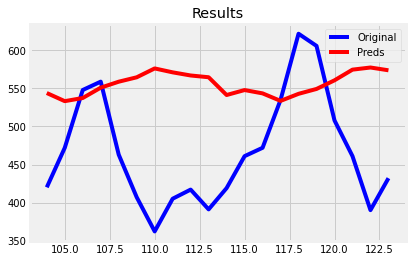

In [23]:
import matplotlib.pyplot as plt
plt.plot(holdout_df[target], color="blue", label="Original")
plt.plot(holdout_df["predicted_value"], color="red", label="Preds")
plt.legend(loc="best")
plt.title("Results")
plt.show()

In [24]:
holdout_df[[target, "predicted_value"]]

,#Passengers_lead20,predicted_value
104,420.0,544.025638
105,472.0,533.339073
106,548.0,537.476372
107,559.0,551.087892
108,463.0,558.922265
109,407.0,564.704726
110,362.0,576.372036
111,405.0,571.227882
112,417.0,567.105604
113,391.0,564.774393


If a dataset has 50 or more columns RNN & LSTM will run with a more complex architecture. These default settings can be adjusted in the ts.rnn_settings class attribute, which stores the settings as a dictionary (lstm_settings for LSTM respectively).

Our performance has not been very good. Let's check the settings underneath:

In [25]:
ts.rnn_settings

{'train_batch_size': 32,
 'test_batch_size': 32,
 'pred_batch_size': 32,
 'drop_out': 0.2,
 'layer_dim': 3,
 'hidden_dim': 512,
 'num_workers': 4,
 'learning_rate': 0.01,
 'weight_decay': 1e-05,
 'seq_len': 5,
 'regression_loss': 'mse',
 'epochs': 100,
 'nb_model_to_create': 1,
 'transformer_model_path': None,
 'model_save_states_path': {None},
 'keep_best_model_only': False}

# Next try with adjusted settings

In [26]:
ts = tsb.TimeSeriesBluePrint(datasource=time_df,
                                       target_variable=target,
                                       preferred_training_mode='auto',
                                       ml_task='time_series',
                                       rapids_acceleration=False,
                                       cat_encoder_model='target')

ts.rnn_settings["layer_dim"] = 2
ts.rnn_settings["hidden_dim"] = 256

Ml task is time_series
Preferred training mode auto has been chosen. e2eml will automatically detect, if LGBM and Xgboost can use GPU acceleration and optimize the workflow accordingly.


In [27]:
ts.ml_bp103_multivariate_timeseries_full_processing_rnn()

Started Execute test train split at 11:53:49.
Started Started column type detection and casting at 11:53:49.
Started Checking for duplicate columns at 11:53:49.
Started Reset dataframe index. at 11:53:49.
Started Delete columns with high share of NULLs at 11:53:50.
Started Apply datetime transformation at 11:53:50.
Started Execute categorical encoding at 11:53:50.
Started Fill nulls at 11:53:50.


  0%|                                                   | 0/100 [00:00<?, ?it/s]

---------------0start-------------
trainscore is 0.44536631952790917


  1%|▍                                          | 1/100 [00:00<00:26,  3.77it/s]

valscore is 0.4734551116622248
Save first model
---------------1start-------------
trainscore is 0.466234993068252


  2%|▊                                          | 2/100 [00:00<00:26,  3.65it/s]

valscore is 0.17875282556519487
found better point
---------------2start-------------
trainscore is 0.2662756195285962


  3%|█▎                                         | 3/100 [00:00<00:26,  3.72it/s]

valscore is 0.17462162875878706
found better point
---------------3start-------------
trainscore is 0.17080779692793704


  4%|█▋                                         | 4/100 [00:01<00:25,  3.70it/s]

valscore is 0.5689745757918943
---------------4start-------------
trainscore is 0.22927622360758076


  5%|██▏                                        | 5/100 [00:01<00:24,  3.82it/s]

valscore is 0.1635768152598628
found better point
---------------5start-------------
trainscore is 0.1619793882350464


  6%|██▌                                        | 6/100 [00:01<00:24,  3.83it/s]

valscore is 0.31532690327892715
---------------6start-------------
trainscore is 0.23075111748262458


  7%|███                                        | 7/100 [00:01<00:23,  3.99it/s]

valscore is 0.29661227807544105
---------------7start-------------
trainscore is 0.1517492913847574


  8%|███▍                                       | 8/100 [00:02<00:23,  3.98it/s]

valscore is 0.22762748266864746
---------------8start-------------
trainscore is 0.23378803478344126


  9%|███▊                                       | 9/100 [00:02<00:23,  3.95it/s]

valscore is 0.4670732232011437
---------------9start-------------
trainscore is 0.25008873300693624


 10%|████▏                                     | 10/100 [00:02<00:22,  3.96it/s]

valscore is 0.3409072465678757
---------------10start-------------
trainscore is 0.18645150615772774


 11%|████▌                                     | 11/100 [00:02<00:23,  3.78it/s]

valscore is 0.14148682586283748
found better point
---------------11start-------------
trainscore is 0.15498535788815962


 12%|█████                                     | 12/100 [00:03<00:23,  3.80it/s]

valscore is 0.14321350991990714
---------------12start-------------
trainscore is 0.11644514015201234


 13%|█████▍                                    | 13/100 [00:03<00:23,  3.72it/s]

valscore is 0.18001527799408026
---------------13start-------------
trainscore is 0.08962770189469198


 14%|█████▉                                    | 14/100 [00:03<00:23,  3.71it/s]

valscore is 0.10450864559200496
found better point
---------------14start-------------
trainscore is 0.10001339862639493


 15%|██████▎                                   | 15/100 [00:03<00:22,  3.72it/s]

valscore is 0.1729556232554776
---------------15start-------------
trainscore is 0.11631201252937373


 16%|██████▋                                   | 16/100 [00:04<00:22,  3.74it/s]

valscore is 0.1437623918780396
---------------16start-------------
trainscore is 0.09982358172401204


 17%|███████▏                                  | 17/100 [00:04<00:22,  3.69it/s]

valscore is 0.09255922531953671
found better point
---------------17start-------------
trainscore is 0.10282432968540933


 18%|███████▌                                  | 18/100 [00:04<00:22,  3.66it/s]

valscore is 0.1054156900983834
---------------18start-------------
trainscore is 0.07945800051009391


 19%|███████▉                                  | 19/100 [00:05<00:22,  3.63it/s]

valscore is 0.25861114619066194
---------------19start-------------
trainscore is 0.10736643479659566


 20%|████████▍                                 | 20/100 [00:05<00:21,  3.71it/s]

valscore is 0.1003667205801986
---------------20start-------------
trainscore is 0.09360422035260048


 21%|████████▊                                 | 21/100 [00:05<00:22,  3.59it/s]

valscore is 0.09155080542347722
found better point
---------------21start-------------
trainscore is 0.07375301533182343


 22%|█████████▏                                | 22/100 [00:05<00:21,  3.69it/s]

valscore is 0.13407736520765143
---------------22start-------------
trainscore is 0.0727308200801714


 23%|█████████▋                                | 23/100 [00:06<00:20,  3.72it/s]

valscore is 0.12024402859421623
---------------23start-------------
trainscore is 0.08666362944865705


 24%|██████████                                | 24/100 [00:06<00:20,  3.70it/s]

valscore is 0.08968286259408208
found better point
---------------24start-------------
trainscore is 0.050984011496458176


 25%|██████████▌                               | 25/100 [00:06<00:19,  3.86it/s]

valscore is 0.09129641439791797
---------------25start-------------
trainscore is 0.05587234759355143


 26%|██████████▉                               | 26/100 [00:06<00:20,  3.70it/s]

valscore is 0.08554927815029766
found better point
---------------26start-------------
trainscore is 0.052192605475884696


 27%|███████████▎                              | 27/100 [00:07<00:19,  3.73it/s]

valscore is 0.13830565252881896
---------------27start-------------
trainscore is 0.0635535342871653


 28%|███████████▊                              | 28/100 [00:07<00:19,  3.68it/s]

valscore is 0.10578305703848968
---------------28start-------------
trainscore is 0.0680753947995629


 29%|████████████▏                             | 29/100 [00:07<00:19,  3.70it/s]

valscore is 0.09351084750052213
---------------29start-------------
trainscore is 0.049814419374355316


 30%|████████████▌                             | 30/100 [00:08<00:19,  3.64it/s]

valscore is 0.1409587121042156
---------------30start-------------
trainscore is 0.06060942056628738


 31%|█████████████                             | 31/100 [00:08<00:18,  3.64it/s]

valscore is 0.1420205640764229
---------------31start-------------
trainscore is 0.04887775905789877


 32%|█████████████▍                            | 32/100 [00:08<00:17,  3.78it/s]

valscore is 0.08167912515114739
found better point
---------------32start-------------
trainscore is 0.051517276618401275


 33%|█████████████▊                            | 33/100 [00:08<00:17,  3.74it/s]

valscore is 0.0847540366610004
---------------33start-------------
trainscore is 0.04711167838290856


 34%|██████████████▎                           | 34/100 [00:09<00:17,  3.71it/s]

valscore is 0.08348725773638713
---------------34start-------------
trainscore is 0.0475553472898235


 35%|██████████████▋                           | 35/100 [00:09<00:17,  3.68it/s]

valscore is 0.08650643286676686
---------------35start-------------
trainscore is 0.03487104057607909


 36%|███████████████                           | 36/100 [00:09<00:17,  3.67it/s]

valscore is 0.08059531635529127
found better point
---------------36start-------------
trainscore is 0.05438818188208497


 37%|███████████████▌                          | 37/100 [00:09<00:16,  3.77it/s]

valscore is 0.19921422082043672
---------------37start-------------
trainscore is 0.07463092389353713


 38%|███████████████▉                          | 38/100 [00:10<00:16,  3.71it/s]

valscore is 0.08297851618501378
---------------38start-------------
trainscore is 0.04932146081505454


 39%|████████████████▍                         | 39/100 [00:10<00:16,  3.77it/s]

valscore is 0.09563623736103434
---------------39start-------------
trainscore is 0.0615486675679057


 40%|████████████████▊                         | 40/100 [00:10<00:16,  3.72it/s]

valscore is 0.18943367518126253
---------------40start-------------
trainscore is 0.08249748162935246


 41%|█████████████████▏                        | 41/100 [00:10<00:15,  3.71it/s]

valscore is 0.08994887651388384
---------------41start-------------
trainscore is 0.04459140095006415


 42%|█████████████████▋                        | 42/100 [00:11<00:15,  3.71it/s]

valscore is 0.10280473910187045
---------------42start-------------
trainscore is 0.03841915751899384


 43%|██████████████████                        | 43/100 [00:11<00:14,  3.82it/s]

valscore is 0.15006638804966999
---------------43start-------------
trainscore is 0.043812751005620036


 44%|██████████████████▍                       | 44/100 [00:11<00:14,  3.78it/s]

valscore is 0.08084642204432885
---------------44start-------------
trainscore is 0.03469246816439488


 45%|██████████████████▉                       | 45/100 [00:12<00:14,  3.77it/s]

valscore is 0.09221239926531588
---------------45start-------------
trainscore is 0.03150972339132485


 46%|███████████████████▎                      | 46/100 [00:12<00:14,  3.74it/s]

valscore is 0.0947265864204631
---------------46start-------------
trainscore is 0.032357981022318454


 47%|███████████████████▋                      | 47/100 [00:12<00:14,  3.71it/s]

valscore is 0.12741428995358625
---------------47start-------------
trainscore is 0.02663610763107982


 48%|████████████████████▏                     | 48/100 [00:12<00:13,  3.75it/s]

valscore is 0.14075243399759987
---------------48start-------------
trainscore is 0.03242151861412835


 49%|████████████████████▌                     | 49/100 [00:13<00:13,  3.83it/s]

valscore is 0.10166760043021877
---------------49start-------------
trainscore is 0.02591613368558105


 50%|█████████████████████                     | 50/100 [00:13<00:13,  3.79it/s]

valscore is 0.08716436681439599
---------------50start-------------
trainscore is 0.026533707677626105


 51%|█████████████████████▍                    | 51/100 [00:13<00:13,  3.74it/s]

valscore is 0.11009915029721375
---------------51start-------------
trainscore is 0.025648451310667463


 52%|█████████████████████▊                    | 52/100 [00:13<00:13,  3.68it/s]

valscore is 0.13185185905489444
---------------52start-------------
trainscore is 0.03210450753661047


 53%|██████████████████████▎                   | 53/100 [00:14<00:12,  3.67it/s]

valscore is 0.1317958818072581
---------------53start-------------
trainscore is 0.034993908550907


 54%|██████████████████████▋                   | 54/100 [00:14<00:12,  3.74it/s]

valscore is 0.10152287270101101
---------------54start-------------
trainscore is 0.023266813034116835


 55%|███████████████████████                   | 55/100 [00:14<00:11,  3.77it/s]

valscore is 0.10304309920694633
---------------55start-------------
trainscore is 0.02553520547212089


 56%|███████████████████████▌                  | 56/100 [00:14<00:11,  3.73it/s]

valscore is 0.09887419195824565
---------------56start-------------
trainscore is 0.019387914435596138


 57%|███████████████████████▉                  | 57/100 [00:15<00:11,  3.85it/s]

valscore is 0.12449512625641565
---------------57start-------------
trainscore is 0.021310471662293447


 58%|████████████████████████▎                 | 58/100 [00:15<00:11,  3.75it/s]

valscore is 0.1327178729644662
---------------58start-------------
trainscore is 0.021121377488080018


 59%|████████████████████████▊                 | 59/100 [00:15<00:10,  3.74it/s]

valscore is 0.1115274152302675
---------------59start-------------
trainscore is 0.021913955902566333


 60%|█████████████████████████▏                | 60/100 [00:16<00:10,  3.69it/s]

valscore is 0.1081787238169068
---------------60start-------------
trainscore is 0.02586765962299061


 61%|█████████████████████████▌                | 61/100 [00:16<00:10,  3.61it/s]

valscore is 0.08014401812817838
found better point
---------------61start-------------
trainscore is 0.03338443563878097


 62%|██████████████████████████                | 62/100 [00:16<00:10,  3.60it/s]

valscore is 0.17028379077791317
---------------62start-------------
trainscore is 0.0420751520138798


 63%|██████████████████████████▍               | 63/100 [00:16<00:10,  3.56it/s]

valscore is 0.07629776744616275
found better point
---------------63start-------------
trainscore is 0.04113342516547514


 64%|██████████████████████████▉               | 64/100 [00:17<00:10,  3.57it/s]

valscore is 0.150074980025829
---------------64start-------------
trainscore is 0.03822421706980421


 65%|███████████████████████████▎              | 65/100 [00:17<00:09,  3.52it/s]

valscore is 0.07578136586435186
found better point
---------------65start-------------
trainscore is 0.03487790533138893


 66%|███████████████████████████▋              | 66/100 [00:17<00:09,  3.63it/s]

valscore is 0.13484539805708642
---------------66start-------------
trainscore is 0.03054296511603715


 67%|████████████████████████████▏             | 67/100 [00:17<00:08,  3.75it/s]

valscore is 0.07738317122080966
---------------67start-------------
trainscore is 0.03668628733979209


 68%|████████████████████████████▌             | 68/100 [00:18<00:08,  3.74it/s]

valscore is 0.1313089439571514
---------------68start-------------
trainscore is 0.029822969544281864


 69%|████████████████████████████▉             | 69/100 [00:18<00:08,  3.77it/s]

valscore is 0.07571096553829118
found better point
---------------69start-------------
trainscore is 0.03651227975871002


 70%|█████████████████████████████▍            | 70/100 [00:18<00:07,  3.91it/s]

valscore is 0.1783713292899933
---------------70start-------------
trainscore is 0.04945778251648951


 71%|█████████████████████████████▊            | 71/100 [00:19<00:07,  3.86it/s]

valscore is 0.08629180034883735
---------------71start-------------
trainscore is 0.040866664711361696


 72%|██████████████████████████████▏           | 72/100 [00:19<00:07,  3.94it/s]

valscore is 0.08271793451123723
---------------72start-------------
trainscore is 0.030830315436940002


 73%|██████████████████████████████▋           | 73/100 [00:19<00:07,  3.85it/s]

valscore is 0.12109197208605225
---------------73start-------------
trainscore is 0.02699895965255872


 74%|███████████████████████████████           | 74/100 [00:19<00:06,  3.82it/s]

valscore is 0.0741926046095442
found better point
---------------74start-------------
trainscore is 0.03300581266949248


 75%|███████████████████████████████▌          | 75/100 [00:20<00:06,  3.82it/s]

valscore is 0.1149561822612301
---------------75start-------------
trainscore is 0.025416447151812238


 76%|███████████████████████████████▉          | 76/100 [00:20<00:06,  3.73it/s]

valscore is 0.09393460732902302
---------------76start-------------
trainscore is 0.02334848694020239


 77%|████████████████████████████████▎         | 77/100 [00:20<00:06,  3.69it/s]

valscore is 0.09868599789127007
---------------77start-------------
trainscore is 0.02295478351408104


 78%|████████████████████████████████▊         | 78/100 [00:20<00:05,  3.73it/s]

valscore is 0.11627235436080477
---------------78start-------------
trainscore is 0.020054414639615676


 79%|█████████████████████████████████▏        | 79/100 [00:21<00:05,  3.75it/s]

valscore is 0.08841467266747807
---------------79start-------------
trainscore is 0.019119806643320355


 80%|█████████████████████████████████▌        | 80/100 [00:21<00:05,  3.72it/s]

valscore is 0.1229135517041764
---------------80start-------------
trainscore is 0.016469688785767368


 81%|██████████████████████████████████        | 81/100 [00:21<00:05,  3.72it/s]

valscore is 0.10775285378650133
---------------81start-------------
trainscore is 0.014609148609997735


 82%|██████████████████████████████████▍       | 82/100 [00:21<00:04,  3.66it/s]

valscore is 0.11404075171714403
---------------82start-------------
trainscore is 0.013700092788096606


 83%|██████████████████████████████████▊       | 83/100 [00:22<00:04,  3.69it/s]

valscore is 0.11442509220704426
---------------83start-------------
trainscore is 0.013573601546948073


 84%|███████████████████████████████████▎      | 84/100 [00:22<00:04,  3.74it/s]

valscore is 0.10958864412742755
---------------84start-------------
trainscore is 0.013161952259329654


 85%|███████████████████████████████████▋      | 85/100 [00:22<00:03,  3.76it/s]

valscore is 0.11046211373591056
---------------85start-------------
trainscore is 0.013025968853579623


 86%|████████████████████████████████████      | 86/100 [00:23<00:03,  3.73it/s]

valscore is 0.11142911094777819
---------------86start-------------
trainscore is 0.0128415871503486


 87%|████████████████████████████████████▌     | 87/100 [00:23<00:03,  3.67it/s]

valscore is 0.11128424866867721
---------------87start-------------
trainscore is 0.012839108255561928


 88%|████████████████████████████████████▉     | 88/100 [00:23<00:03,  3.63it/s]

valscore is 0.11128424866867721
---------------88start-------------
trainscore is 0.012839108255561928


 89%|█████████████████████████████████████▍    | 89/100 [00:23<00:02,  3.75it/s]

valscore is 0.11128424866867721
---------------89start-------------
trainscore is 0.012839108255561928


 90%|█████████████████████████████████████▊    | 90/100 [00:24<00:02,  3.79it/s]

valscore is 0.11128424866867721
---------------90start-------------
trainscore is 0.012839108255561928


 91%|██████████████████████████████████████▏   | 91/100 [00:24<00:02,  3.71it/s]

valscore is 0.11128424866867721
---------------91start-------------
trainscore is 0.012839108255561928


 92%|██████████████████████████████████████▋   | 92/100 [00:24<00:02,  3.73it/s]

valscore is 0.11128424866867721
---------------92start-------------
trainscore is 0.012839108255561928


 93%|███████████████████████████████████████   | 93/100 [00:24<00:01,  3.75it/s]

valscore is 0.11128424866867721
---------------93start-------------
trainscore is 0.012839108255561928


 94%|███████████████████████████████████████▍  | 94/100 [00:25<00:01,  3.80it/s]

valscore is 0.11128424866867721
---------------94start-------------
trainscore is 0.012839108255561928


 95%|███████████████████████████████████████▉  | 95/100 [00:25<00:01,  3.82it/s]

valscore is 0.11128424866867721
---------------95start-------------
trainscore is 0.012839108255561928


 96%|████████████████████████████████████████▎ | 96/100 [00:25<00:01,  3.75it/s]

valscore is 0.11128424866867721
---------------96start-------------
trainscore is 0.012839108255561928


 97%|████████████████████████████████████████▋ | 97/100 [00:25<00:00,  3.73it/s]

valscore is 0.11128424866867721
---------------97start-------------
trainscore is 0.012839108255561928


 98%|█████████████████████████████████████████▏| 98/100 [00:26<00:00,  3.76it/s]

valscore is 0.11128424866867721
---------------98start-------------
trainscore is 0.012839108255561928


 99%|█████████████████████████████████████████▌| 99/100 [00:26<00:00,  3.67it/s]

valscore is 0.11128424866867721
---------------99start-------------
trainscore is 0.012839108255561928


100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.73it/s]


valscore is 0.11128424866867721


  0%|                                                   | 0/100 [00:00<?, ?it/s]

---------------0start-------------
trainscore is 0.5448424510531714


  1%|▍                                          | 1/100 [00:00<00:28,  3.46it/s]

valscore is 0.2451748751157803
Save first model
---------------1start-------------
trainscore is 0.3759193291630562


  2%|▊                                          | 2/100 [00:00<00:26,  3.66it/s]

valscore is 0.14590035763938833
found better point
---------------2start-------------
trainscore is 0.27191982412808047


  3%|█▎                                         | 3/100 [00:00<00:26,  3.72it/s]

valscore is 0.22142013320305354
---------------3start-------------
trainscore is 0.28308110362469435


  4%|█▋                                         | 4/100 [00:01<00:25,  3.70it/s]

valscore is 0.5645475813088119
---------------4start-------------
trainscore is 0.507019719924644


  5%|██▏                                        | 5/100 [00:01<00:25,  3.79it/s]

valscore is 0.5716742279488397
---------------5start-------------
trainscore is 0.30836700341088624


  6%|██▌                                        | 6/100 [00:01<00:24,  3.83it/s]

valscore is 0.5384412493968778
---------------6start-------------
trainscore is 0.37999674564891195


  7%|███                                        | 7/100 [00:01<00:24,  3.73it/s]

valscore is 0.7676722650166575
---------------7start-------------
trainscore is 0.3774527014480519


  8%|███▍                                       | 8/100 [00:02<00:25,  3.67it/s]

valscore is 0.24632755701466796
---------------8start-------------
trainscore is 0.36269981338775


  9%|███▊                                       | 9/100 [00:02<00:24,  3.77it/s]

valscore is 0.5580817265361577
---------------9start-------------
trainscore is 0.26580360337818887


 10%|████▏                                     | 10/100 [00:02<00:23,  3.82it/s]

valscore is 0.18027972656545238
---------------10start-------------
trainscore is 0.30094117361597045


 11%|████▌                                     | 11/100 [00:02<00:23,  3.76it/s]

valscore is 0.5789555980681914
---------------11start-------------
trainscore is 0.30066632232352253


 12%|█████                                     | 12/100 [00:03<00:23,  3.75it/s]

valscore is 0.2907295857254124
---------------12start-------------
trainscore is 0.2666082070415059


 13%|█████▍                                    | 13/100 [00:03<00:23,  3.77it/s]

valscore is 0.1801707844175445
---------------13start-------------
trainscore is 0.1936177882272551


 14%|█████▉                                    | 14/100 [00:03<00:21,  3.91it/s]

valscore is 0.381831961423915
---------------14start-------------
trainscore is 0.2030840164099719


 15%|██████▎                                   | 15/100 [00:03<00:21,  3.95it/s]

valscore is 0.23785838751091506
---------------15start-------------
trainscore is 0.26515788694038317


 16%|██████▋                                   | 16/100 [00:04<00:20,  4.02it/s]

valscore is 0.3102368983472972
---------------16start-------------
trainscore is 0.28685048174346306


 17%|███████▏                                  | 17/100 [00:04<00:20,  3.99it/s]

valscore is 0.39598541688696254
---------------17start-------------
trainscore is 0.18891723192342047


 18%|███████▌                                  | 18/100 [00:04<00:20,  3.97it/s]

valscore is 0.19770427797574788
---------------18start-------------
trainscore is 0.3222239676986214


 19%|███████▉                                  | 19/100 [00:04<00:21,  3.85it/s]

valscore is 0.15502272658059854
---------------19start-------------
trainscore is 0.17057448186244792


 20%|████████▍                                 | 20/100 [00:05<00:20,  3.95it/s]

valscore is 0.32484352524650756
---------------20start-------------
trainscore is 0.2671501710150727


 21%|████████▊                                 | 21/100 [00:05<00:20,  3.84it/s]

valscore is 0.16120589595839513
---------------21start-------------
trainscore is 0.19616232052985447


 22%|█████████▏                                | 22/100 [00:05<00:20,  3.75it/s]

valscore is 0.2193022727029575
---------------22start-------------
trainscore is 0.18642116146627402


 23%|█████████▋                                | 23/100 [00:06<00:21,  3.64it/s]

valscore is 0.26594296210765594
---------------23start-------------
trainscore is 0.1821604407551372


 24%|██████████                                | 24/100 [00:06<00:20,  3.66it/s]

valscore is 0.2838144184642311
---------------24start-------------
trainscore is 0.15903835748170925


 25%|██████████▌                               | 25/100 [00:06<00:20,  3.68it/s]

valscore is 0.15346034242877307
---------------25start-------------
trainscore is 0.1718254300549017


 26%|██████████▉                               | 26/100 [00:06<00:19,  3.70it/s]

valscore is 0.1597253872793222
---------------26start-------------
trainscore is 0.11780284001258429


 27%|███████████▎                              | 27/100 [00:07<00:19,  3.79it/s]

valscore is 0.1625027571322744
---------------27start-------------
trainscore is 0.14617790594958047


 28%|███████████▊                              | 28/100 [00:07<00:18,  3.82it/s]

valscore is 0.2154520227594197
---------------28start-------------
trainscore is 0.15809654506990944


 29%|████████████▏                             | 29/100 [00:07<00:18,  3.88it/s]

valscore is 0.17946498153957421
---------------29start-------------
trainscore is 0.11509369587389587


 30%|████████████▌                             | 30/100 [00:07<00:17,  3.91it/s]

valscore is 0.1543418339383905
---------------30start-------------
trainscore is 0.10814886341529925


 31%|█████████████                             | 31/100 [00:08<00:18,  3.82it/s]

valscore is 0.1556035956590809
---------------31start-------------
trainscore is 0.11838400390169879


 32%|█████████████▍                            | 32/100 [00:08<00:17,  3.79it/s]

valscore is 0.15319601146754117
---------------32start-------------
trainscore is 0.1174114931609043


 33%|█████████████▊                            | 33/100 [00:08<00:18,  3.66it/s]

valscore is 0.15496071281918183
---------------33start-------------
trainscore is 0.090004785905536


 34%|██████████████▎                           | 34/100 [00:08<00:18,  3.64it/s]

valscore is 0.1949181211629058
---------------34start-------------
trainscore is 0.1107972414886832


 35%|██████████████▋                           | 35/100 [00:09<00:17,  3.75it/s]

valscore is 0.19373009806683522
---------------35start-------------
trainscore is 0.11110476936654166


 36%|███████████████                           | 36/100 [00:09<00:16,  3.83it/s]

valscore is 0.15860550425131617
---------------36start-------------
trainscore is 0.12196380708497041


 37%|███████████████▌                          | 37/100 [00:09<00:16,  3.75it/s]

valscore is 0.22365233915751218
---------------37start-------------
trainscore is 0.10270971932063062


 38%|███████████████▉                          | 38/100 [00:10<00:15,  3.91it/s]

valscore is 0.20633676614995594
---------------38start-------------
trainscore is 0.08840012444372289


 39%|████████████████▍                         | 39/100 [00:10<00:15,  3.85it/s]

valscore is 0.1487813173923779
---------------39start-------------
trainscore is 0.09664248124891006


 40%|████████████████▊                         | 40/100 [00:10<00:15,  3.81it/s]

valscore is 0.18049826902873145
---------------40start-------------
trainscore is 0.12132255899879639


 41%|█████████████████▏                        | 41/100 [00:10<00:15,  3.72it/s]

valscore is 0.19091609489222283
---------------41start-------------
trainscore is 0.09800244637816216


 42%|█████████████████▋                        | 42/100 [00:11<00:15,  3.68it/s]

valscore is 0.15098389750266072
---------------42start-------------
trainscore is 0.09521949198175263


 43%|██████████████████                        | 43/100 [00:11<00:15,  3.69it/s]

valscore is 0.22728810874703617
---------------43start-------------
trainscore is 0.09028571281374248


 44%|██████████████████▍                       | 44/100 [00:11<00:14,  3.84it/s]

valscore is 0.2986591741372091
---------------44start-------------
trainscore is 0.09352555042110537


 45%|██████████████████▉                       | 45/100 [00:11<00:14,  3.68it/s]

valscore is 0.19955061809732624
---------------45start-------------
trainscore is 0.12096487667598588


 46%|███████████████████▎                      | 46/100 [00:12<00:14,  3.74it/s]

valscore is 0.19922271951672452
---------------46start-------------
trainscore is 0.08942319839817832


 47%|███████████████████▋                      | 47/100 [00:12<00:14,  3.73it/s]

valscore is 0.29069362028930307
---------------47start-------------
trainscore is 0.10845793568023045


 48%|████████████████████▏                     | 48/100 [00:12<00:13,  3.84it/s]

valscore is 0.21320905861215897
---------------48start-------------
trainscore is 0.07928138612765279


 49%|████████████████████▌                     | 49/100 [00:12<00:13,  3.83it/s]

valscore is 0.1384045165278385
found better point
---------------49start-------------
trainscore is 0.1135559537125088


 50%|█████████████████████                     | 50/100 [00:13<00:13,  3.72it/s]

valscore is 0.15036146568964934
---------------50start-------------
trainscore is 0.09440813891879946


 51%|█████████████████████▍                    | 51/100 [00:13<00:12,  3.78it/s]

valscore is 0.205660366818846
---------------51start-------------
trainscore is 0.11092733926503162


 52%|█████████████████████▊                    | 52/100 [00:13<00:12,  3.89it/s]

valscore is 0.16411067624510117
---------------52start-------------
trainscore is 0.06867727692446864


 53%|██████████████████████▎                   | 53/100 [00:13<00:12,  3.78it/s]

valscore is 0.13858601129461293
---------------53start-------------
trainscore is 0.09171663416342062


 54%|██████████████████████▋                   | 54/100 [00:14<00:11,  3.92it/s]

valscore is 0.18681517325642719
---------------54start-------------
trainscore is 0.07980716962509374


 55%|███████████████████████                   | 55/100 [00:14<00:11,  3.98it/s]

valscore is 0.26998496262829663
---------------55start-------------
trainscore is 0.1015599961245427


 56%|███████████████████████▌                  | 56/100 [00:14<00:10,  4.03it/s]

valscore is 0.21217630834822662
---------------56start-------------
trainscore is 0.07508442977756073


 57%|███████████████████████▉                  | 57/100 [00:14<00:10,  3.93it/s]

valscore is 0.15820088622447828
---------------57start-------------
trainscore is 0.09111263021839092


 58%|████████████████████████▎                 | 58/100 [00:15<00:10,  3.83it/s]

valscore is 0.1907123461591874
---------------58start-------------
trainscore is 0.06336416549696343


 59%|████████████████████████▊                 | 59/100 [00:15<00:10,  3.79it/s]

valscore is 0.24008010253459328
---------------59start-------------
trainscore is 0.08442364234941466


 60%|█████████████████████████▏                | 60/100 [00:15<00:10,  3.83it/s]

valscore is 0.18537063894450467
---------------60start-------------
trainscore is 0.06711811053234738


 61%|█████████████████████████▌                | 61/100 [00:16<00:10,  3.82it/s]

valscore is 0.1345714752957146
found better point
---------------61start-------------
trainscore is 0.0909763198046816


 62%|██████████████████████████                | 62/100 [00:16<00:10,  3.72it/s]

valscore is 0.14828838270454986
---------------62start-------------
trainscore is 0.05984264168662491


 63%|██████████████████████████▍               | 63/100 [00:16<00:09,  3.72it/s]

valscore is 0.20598058181557904
---------------63start-------------
trainscore is 0.08619960727961683


 64%|██████████████████████████▉               | 64/100 [00:16<00:09,  3.89it/s]

valscore is 0.2314542273460146
---------------64start-------------
trainscore is 0.06911995608117383


 65%|███████████████████████████▎              | 65/100 [00:17<00:09,  3.80it/s]

valscore is 0.17911077403785966
---------------65start-------------
trainscore is 0.0636272114481934


 66%|███████████████████████████▋              | 66/100 [00:17<00:08,  3.83it/s]

valscore is 0.15997943742943743
---------------66start-------------
trainscore is 0.07694698946286933


 67%|████████████████████████████▏             | 67/100 [00:17<00:08,  3.87it/s]

valscore is 0.2073191543138255
---------------67start-------------
trainscore is 0.06303224104512938


 68%|████████████████████████████▌             | 68/100 [00:17<00:08,  3.90it/s]

valscore is 0.27374393507820016
---------------68start-------------
trainscore is 0.08731308939615175


 69%|████████████████████████████▉             | 69/100 [00:18<00:07,  4.03it/s]

valscore is 0.2591899056374882
---------------69start-------------
trainscore is 0.06392479019167402


 70%|█████████████████████████████▍            | 70/100 [00:18<00:07,  3.92it/s]

valscore is 0.19115705166313315
---------------70start-------------
trainscore is 0.06464768805102215


 71%|█████████████████████████████▊            | 71/100 [00:18<00:07,  3.85it/s]

valscore is 0.15868259901034473
---------------71start-------------
trainscore is 0.07102205621762246


 72%|██████████████████████████████▏           | 72/100 [00:18<00:07,  3.68it/s]

valscore is 0.17694054746237758
---------------72start-------------
trainscore is 0.05134782579403005


 73%|██████████████████████████████▋           | 73/100 [00:19<00:07,  3.79it/s]

valscore is 0.21605345833567385
---------------73start-------------
trainscore is 0.07066705920033836


 74%|███████████████████████████████           | 74/100 [00:19<00:06,  3.92it/s]

valscore is 0.21745848665724943
---------------74start-------------
trainscore is 0.0677877498836197


 75%|███████████████████████████████▌          | 75/100 [00:19<00:06,  4.04it/s]

valscore is 0.18180446059130204
---------------75start-------------
trainscore is 0.05137018696348446


 76%|███████████████████████████████▉          | 76/100 [00:19<00:06,  3.90it/s]

valscore is 0.15097233368782095
---------------76start-------------
trainscore is 0.06424232778349347


 77%|████████████████████████████████▎         | 77/100 [00:20<00:06,  3.83it/s]

valscore is 0.14675899834249975
---------------77start-------------
trainscore is 0.06412643171069034


 78%|████████████████████████████████▊         | 78/100 [00:20<00:05,  3.79it/s]

valscore is 0.16616847789559352
---------------78start-------------
trainscore is 0.047760079521106176


 79%|█████████████████████████████████▏        | 79/100 [00:20<00:05,  3.78it/s]

valscore is 0.19788197225049545
---------------79start-------------
trainscore is 0.05163214454430547


 80%|█████████████████████████████████▌        | 80/100 [00:21<00:05,  3.76it/s]

valscore is 0.21806044849659997
---------------80start-------------
trainscore is 0.057375935485904445


 81%|██████████████████████████████████        | 81/100 [00:21<00:05,  3.70it/s]

valscore is 0.2179451310150427
---------------81start-------------
trainscore is 0.049671478621339415


 82%|██████████████████████████████████▍       | 82/100 [00:21<00:04,  3.73it/s]

valscore is 0.20356994405568457
---------------82start-------------
trainscore is 0.04346858861840665


 83%|██████████████████████████████████▊       | 83/100 [00:21<00:04,  3.72it/s]

valscore is 0.1885601212790044
---------------83start-------------
trainscore is 0.047914203996438726


 84%|███████████████████████████████████▎      | 84/100 [00:22<00:04,  3.74it/s]

valscore is 0.18163241884476775
---------------84start-------------
trainscore is 0.05188245169497612


 85%|███████████████████████████████████▋      | 85/100 [00:22<00:04,  3.64it/s]

valscore is 0.18165341385638598
---------------85start-------------
trainscore is 0.051775134472308026


 86%|████████████████████████████████████      | 86/100 [00:22<00:03,  3.65it/s]

valscore is 0.18386927934460243
---------------86start-------------
trainscore is 0.05071382907786016


 87%|████████████████████████████████████▌     | 87/100 [00:22<00:03,  3.60it/s]

valscore is 0.18427509700718916
---------------87start-------------
trainscore is 0.050639352232991416


 88%|████████████████████████████████████▉     | 88/100 [00:23<00:03,  3.55it/s]

valscore is 0.18427509700718916
---------------88start-------------
trainscore is 0.050639352232991416


 89%|█████████████████████████████████████▍    | 89/100 [00:23<00:03,  3.60it/s]

valscore is 0.18427509700718916
---------------89start-------------
trainscore is 0.050639352232991416


 90%|█████████████████████████████████████▊    | 90/100 [00:23<00:02,  3.65it/s]

valscore is 0.18427509700718916
---------------90start-------------
trainscore is 0.050639352232991416


 91%|██████████████████████████████████████▏   | 91/100 [00:24<00:02,  3.78it/s]

valscore is 0.18427509700718916
---------------91start-------------
trainscore is 0.050639352232991416


 92%|██████████████████████████████████████▋   | 92/100 [00:24<00:02,  3.88it/s]

valscore is 0.18427509700718916
---------------92start-------------
trainscore is 0.050639352232991416


 93%|███████████████████████████████████████   | 93/100 [00:24<00:01,  3.85it/s]

valscore is 0.18427509700718916
---------------93start-------------
trainscore is 0.050639352232991416


 94%|███████████████████████████████████████▍  | 94/100 [00:24<00:01,  3.83it/s]

valscore is 0.18427509700718916
---------------94start-------------
trainscore is 0.050639352232991416


 95%|███████████████████████████████████████▉  | 95/100 [00:25<00:01,  3.83it/s]

valscore is 0.18427509700718916
---------------95start-------------
trainscore is 0.050639352232991416


 96%|████████████████████████████████████████▎ | 96/100 [00:25<00:01,  3.74it/s]

valscore is 0.18427509700718916
---------------96start-------------
trainscore is 0.050639352232991416


 97%|████████████████████████████████████████▋ | 97/100 [00:25<00:00,  3.77it/s]

valscore is 0.18427509700718916
---------------97start-------------
trainscore is 0.050639352232991416


 98%|█████████████████████████████████████████▏| 98/100 [00:25<00:00,  3.80it/s]

valscore is 0.18427509700718916
---------------98start-------------
trainscore is 0.050639352232991416


 99%|█████████████████████████████████████████▌| 99/100 [00:26<00:00,  3.79it/s]

valscore is 0.18427509700718916
---------------99start-------------
trainscore is 0.050639352232991416


100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.79it/s]

valscore is 0.18427509700718916
['/home/thomas/Schreibtisch/Data Science/Preprocessing lib test/model0.pth']


Started Target skewness handling at 11:54:44.
The R2 score is -6155927.939468647
The MAE score is 392.16118643174195
The Median absolute error score is 397.90530707235007
The MSE score is 394.15035454583494
The RMSE score is 155354.50198860737


In [28]:
del holdout_df["predicted_value"]
del holdout_df[target] 

In [29]:
holdout_df[target] = 1 # add dummy
ts.ml_bp103_multivariate_timeseries_full_processing_rnn(holdout_df) 

Started Execute test train split at 11:54:44.
Started Started column type detection and casting at 11:54:44.
Started Checking for duplicate columns at 11:54:44.
Started Reset dataframe index. at 11:54:44.
Started Delete columns with high share of NULLs at 11:54:44.
Started Apply datetime transformation at 11:54:44.
Started Execute categorical encoding at 11:54:44.
Started Fill nulls at 11:54:44.
['/home/thomas/Schreibtisch/Data Science/Preprocessing lib test/model0.pth']
Started Target skewness handling at 11:54:44.


In [30]:
holdout_df["predicted_value"] =  ts.predicted_values['rnn'].values
holdout_df[target] = val_df_target

In [31]:
mae = mean_absolute_error(holdout_df[target].fillna(0), holdout_df["predicted_value"])
print(mae)

98.57476670145988


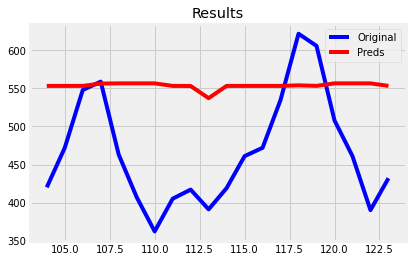

In [32]:
import matplotlib.pyplot as plt
plt.plot(holdout_df[target], color="blue", label="Original")
plt.plot(holdout_df["predicted_value"], color="red", label="Preds")
plt.legend(loc="best")
plt.title("Results")
plt.show()

It got a little better, but is not convincing. Maybe we should reduce the variables created with shift & rolling functions.